## Preprocessing for Feature 

- Before proceed, check if number of polygons matches the number of generated files (polygon-boxes, squares)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure as skie
import skimage
import numpy as np
import glob
import cv2
from cv2 import normalize

from pathlib import Path
from PIL import Image,ImageOps

In [3]:
img_path = '/home/richard/data/Schiefer/clipped_raster_files_polygon/CFB184_ortho_rgb_0003.png'
#img_path = '/home/richard/data/Schiefer/CFB184clipped_raster_files/CFB184_ortho_rgb_0003.png'
img = plt.imread(img_path)
#img = skimage.color.rgb2gray(img) # preserves luminance of img

#### Histogramm normalization

- with CLAHE
  - Two benefits: normalize brightness, reduce differences between darker and light images
  - enhance contrast of image (stronger responses in conv layers)

Kinda only useful for square images otherwise black pixels are appearing too often, but still brightness is normalized.

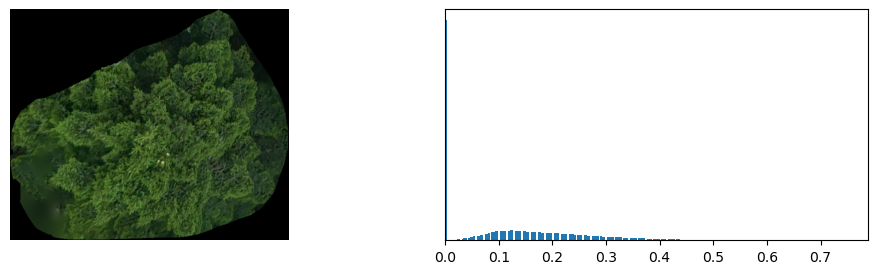

In [4]:
def show(img): #displays image next to a histogram
    # Display the image.
    fig, (ax1, ax2) = plt.subplots(1, 2,
                                   figsize=(12, 3))

    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_axis_off()

    # Display the histogram.
    ax2.hist(img.ravel(), lw=0, bins=256)
    ax2.set_xlim(0, img.max())
    ax2.set_yticks([])

    plt.show()

show(img)

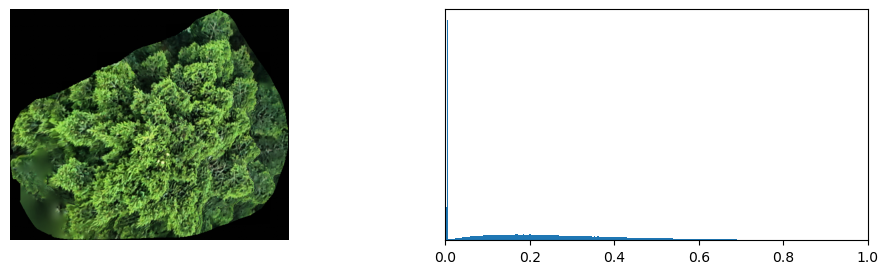

In [5]:
# Contrast Limited Adaptive Histogram Equalization (CLAHE) applied
show(skie.equalize_adapthist(img))
# under the hood works rescale_intensity, equalize_adapthist,

In [ ]:
new = skie.equalize_adapthist(img)
print(type(new))
PIL_image = Image.fromarray((new * 255).astype(np.uint8))
plt.imshow(PIL_image)
print(PIL_image.size)

#### Resize images

VGG16 and ResNet default size = 224. Use this size for square crowns. For whole polygons resize images to 448. So they can be directly fed into the CNN.

#### _____________________

In [4]:
square_crops_path = '/home/richard/data/Schiefer/tests/CFB184_clipped_raster_files_squares/'
polygon_crops_path = '/home/richard/data/Schiefer/CFB184_clipped_raster_files_polygon_v2/'

assert Path(polygon_crops_path).is_dir()
assert Path(square_crops_path).is_dir()

print(Path(square_crops_path).parent / 'preprocessed')

/home/richard/data/Schiefer/tests/preprocessed


In [12]:
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def get_png_file_names(file_dir):
    files = glob.glob(file_dir + '*.png')
    print("num files",len(files))
    return files

def normalize_img(img_arr):
    normalized_img = cv2.normalize(img_arr, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    normalized_img = normalized_img.astype(np.uint8)
    return normalized_img

def highest_pixel_count(img_array):
    pixel, n_of_pixels = np.unique(img_array, return_counts=True)
    highest_pixel_value = pixel[np.argsort(-n_of_pixels)]
    index = 0
    forbidden_values = {0,1,2}
    while True:
        if highest_pixel_value[index] not in forbidden_values:
            return highest_pixel_value[index]
        index += 1
        
    """_summary_
    do it on orthoreference images from schiefer and count the pixels that lie inside the ground truth of schiefer
    """

def preprocess_images(images_path,expected_size):
    out_dir = Path(images_path).parent / Path('preprocessedwithpixel_' + str(expected_size)) 
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    
    file_list = get_png_file_names(images_path)
    for img in file_list:
        file_name = Path(img).stem
        img = plt.imread(img)
        # normalize brightness
        processed_img = skie.equalize_adapthist(img)
        # normalize pixel values to range 0-255
        #processed_img = normalize_img(processed_img) # TODO: Check if result differs when using non normalized values
        # calc pixel count
        #pixel_count = highest_pixel_count(processed_img)
        # array to img
        PIL_image = Image.fromarray((processed_img * 255).astype(np.uint8))
        # resize
        PIL_image = resize_with_padding(PIL_image,(expected_size,expected_size))
        PIL_image.save(str(out_dir) + '/' + str(file_name) + '_preprocessed' + '.png')

In [13]:
preprocess_images(polygon_crops_path,224)

num files 291


#### Test section

In [123]:
imgs_dir = '/home/richard/data/Schiefer/preprocessedwithpixel_224/'
files = glob.glob(imgs_dir + '*.png')
num = []
for f in files:
    f = Path(f).stem
    f = f.split('_')[5]
    num.append(f)

unique, counts = np.unique(num,return_counts=True)
counts = sorted(counts,reverse=True)
print("unique values",len(unique))
for value, number in zip(unique, counts):
    print(value,number)

unique values 5
0 122
10 87
12 71
4 7
8 4


In [119]:
imgs_dir = '/home/richard/data/Schiefer/tests/CFB184_clipped_raster_files/'
files = glob.glob(imgs_dir + '*.png')
print(len(files))
num = []
for f in files:
    f = Path(f).stem
    f = f.split('_')[4]
    num.append(f)

unique, counts = np.unique(num,return_counts=True)
counts = sorted(counts,reverse=True)
print("unique values",len(unique))
for value, number in zip(unique, counts):
    print(value,number)

0
unique values 0


<class 'numpy.ndarray'>
<class 'numpy.float32'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


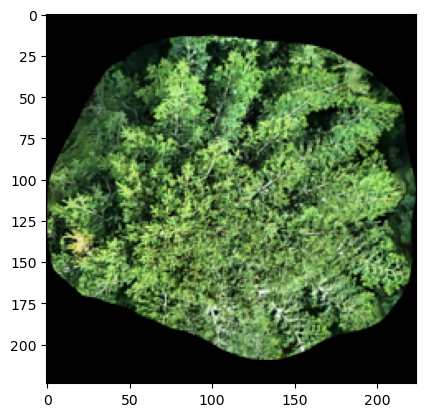

In [86]:
# test one image
img_path = '/home/richard/data/Schiefer/preprocessed_224/CFB184_ortho_rgb_0002_preprocessed.png'
assert Path(img_path).exists()

img_arr = plt.imread(img_path)
print(type(img_arr))
pixel, n_of_pixels = np.unique(img_arr, return_counts=True)
highest_pixel_value = pixel[np.argsort(-n_of_pixels)]
print(type(highest_pixel_value[2]))


new_img = normalize(img_arr, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
new_img = new_img.astype(np.uint8)
print(type(new_img))
plt.imshow(new_img)
print(type(new_img))

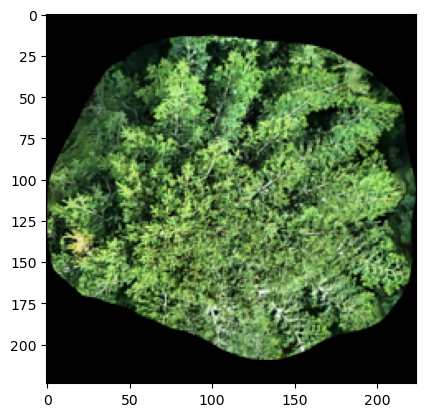

In [81]:
def normalize_img(img_arr):
    normalized_img = cv2.normalize(img_arr, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    normalized_img = normalized_img.astype(np.uint8)
    return normalized_img

def highest_pixel_count(img_array):
    pixel, n_of_pixels = np.unique(img_array, return_counts=True)
    highest_pixel_value = pixel[np.argsort(-n_of_pixels)]
    index = 0
    forbidden_values = {0,1}
    while True:
        if highest_pixel_value[index] not in forbidden_values:
            return highest_pixel_value[index]
        index += 1


new = normalize_img(img_arr)
count = highest_pixel_count(new)


# vis
PIL_image = Image.fromarray(new)
plt.imshow(PIL_image)

In [ ]:
# improve selecting, skip if highest pixel count == 0 or 1 